## Setup google drive

In [0]:
#  run this cell only once
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
#  run this cell only once
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Source code Similarity Detection

In [0]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.layers import concatenate, merge
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Activation, Flatten, Dense, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, BatchNormalization
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils.np_utils import to_categorical

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Plot statistical data such as Annotated heatmaps
import math
import time, datetime

Using TensorFlow backend.


In [0]:
TENSORBOARD_LOGS_PATH = '/content/drive/colab/logs'
CHECKPOINT_FOLDER_PATH = '/content/drive/colab/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

# MAIN_FOLDER = ('/content/drive/colab/LSTM/{}/').format(datetime.datetime.now().isoformat())
MAIN_FOLDER = ('/content/drive/colab/CNN/{}/').format(datetime.datetime.now().isoformat())
# MAIN_FOLDER = ('/content/drive/colab/TEST/{}/').format(datetime.datetime.now().isoformat())

ENCODER_MODEL_PATH = '/content/drive/colab/models/encoder_model2.h5'
ENCODER_MODEL_WEIGHTS_PATH = '/content/drive/colab/models/encoder_model_copy-weights2.h5'
CHECK_POINT_PATH = 'weights.best.hdf5'

# DATASET_PATH = "/content/drive/colab/Datasets/dataset1.csv"
# DATASET_PATH = "/content/drive/colab/Datasets/dataset2.csv"
DATASET_PATH = "/content/drive/colab/Datasets/dataset3.csv"

optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'relu'
batch_size = 64
epochs = 50
dropout = 0.2

# os.mkdir(MAIN_FOLDER)
print(MAIN_FOLDER)

main_information = list()

/content/drive/colab/CNN/2019-04-20T19:01:51.911870/


In [0]:
def save_information(information):
  path = MAIN_FOLDER + 'main_info.txt'
  with open(path, 'w') as fp:
    fp.write("\n".join(information))
  print("Saved into {}".format(path))

# Loading Data

In [0]:
dataset_df = pd.read_csv(DATASET_PATH, header=None)
main_information.append(DATASET_PATH)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 3 columns):
0    10126 non-null int64
1    10126 non-null object
2    10126 non-null object
dtypes: int64(1), object(2)
memory usage: 237.4+ KB


In [0]:
# Store dataset info into main_info
buf = io.StringIO()
dataset_df.info(buf=buf)
info = buf.getvalue()
main_information.append(info)

In [0]:
dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)
# dataset_df.head()
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 3 columns):
0    10126 non-null int64
1    10126 non-null object
2    10126 non-null object
dtypes: int64(1), object(2)
memory usage: 237.4+ KB


In [0]:
print(dataset_df[0].value_counts())
y = dataset_df[0]

1    7092
0    6903
Name: 0, dtype: int64


In [0]:
# Split dataset into train, test, labels
train_left, test_left, train_right, test_right = train_test_split(dataset_df[1].values, dataset_df[2].values, test_size=0.2, shuffle=False)
train_labels, test_labels = train_test_split(y, test_size=0.2, shuffle=False)
# train_labels, test_labels = train_test_split(dataset_df[0].values, test_size=0.2, shuffle=False)

# Copy of original labels which allows us to see wrong predictions
test_left_original, test_right_original = test_left, test_right

In [0]:
train, valid = train_test_split(train_left, test_size=0.2)
trs = "Train set: {}\n".format(len(train))
vas = "Valid set: {}\n".format(len(valid))
tes = "Test set: {}\n".format(len(test_left))
tot = "Total: {}\n".format(len(train) + len(valid) + len(test_left))
print(trs, vas, tes, tot)
main_information.append(trs + vas + tes + tot)

Train set: 6480
 Valid set: 1620
 Test set: 2026
 Total: 10126



In [0]:
# print(len(test_left))
# print(len(test_right))
# print(len(test_labels))
# print(len(train_left))
# print(len(train_right))
print(len(train_labels))
# train_labels

8100


# Preprocessing

In [0]:
# Create tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

In [0]:
def get_alphabet():
    ''' Create alphabet from ASCII character '''
    char_dict = {}
    for num in range(127):
        char_dict[chr(num)] = num + 1
    return char_dict

In [0]:
# Create Alphabet Vocabulary (Dictonary)
char_dict = get_alphabet()
print(char_dict)

{'\x00': 1, '\x01': 2, '\x02': 3, '\x03': 4, '\x04': 5, '\x05': 6, '\x06': 7, '\x07': 8, '\x08': 9, '\t': 10, '\n': 11, '\x0b': 12, '\x0c': 13, '\r': 14, '\x0e': 15, '\x0f': 16, '\x10': 17, '\x11': 18, '\x12': 19, '\x13': 20, '\x14': 21, '\x15': 22, '\x16': 23, '\x17': 24, '\x18': 25, '\x19': 26, '\x1a': 27, '\x1b': 28, '\x1c': 29, '\x1d': 30, '\x1e': 31, '\x1f': 32, ' ': 33, '!': 34, '"': 35, '#': 36, '$': 37, '%': 38, '&': 39, "'": 40, '(': 41, ')': 42, '*': 43, '+': 44, ',': 45, '-': 46, '.': 47, '/': 48, '0': 49, '1': 50, '2': 51, '3': 52, '4': 53, '5': 54, '6': 55, '7': 56, '8': 57, '9': 58, ':': 59, ';': 60, '<': 61, '=': 62, '>': 63, '?': 64, '@': 65, 'A': 66, 'B': 67, 'C': 68, 'D': 69, 'E': 70, 'F': 71, 'G': 72, 'H': 73, 'I': 74, 'J': 75, 'K': 76, 'L': 77, 'M': 78, 'N': 79, 'O': 80, 'P': 81, 'Q': 82, 'R': 83, 'S': 84, 'T': 85, 'U': 86, 'V': 87, 'W': 88, 'X': 89, 'Y': 90, 'Z': 91, '[': 92, '\\': 93, ']': 94, '^': 95, '_': 96, '`': 97, 'a': 98, 'b': 99, 'c': 100, 'd': 101, 'e': 1

In [0]:
# Create vocabulary and Add it into the tokenizer
tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
print(tk.word_index)

{'\x00': 1, '\x01': 2, '\x02': 3, '\x03': 4, '\x04': 5, '\x05': 6, '\x06': 7, '\x07': 8, '\x08': 9, '\t': 10, '\n': 11, '\x0b': 12, '\x0c': 13, '\r': 14, '\x0e': 15, '\x0f': 16, '\x10': 17, '\x11': 18, '\x12': 19, '\x13': 20, '\x14': 21, '\x15': 22, '\x16': 23, '\x17': 24, '\x18': 25, '\x19': 26, '\x1a': 27, '\x1b': 28, '\x1c': 29, '\x1d': 30, '\x1e': 31, '\x1f': 32, ' ': 33, '!': 34, '"': 35, '#': 36, '$': 37, '%': 38, '&': 39, "'": 40, '(': 41, ')': 42, '*': 43, '+': 44, ',': 45, '-': 46, '.': 47, '/': 48, '0': 49, '1': 50, '2': 51, '3': 52, '4': 53, '5': 54, '6': 55, '7': 56, '8': 57, '9': 58, ':': 59, ';': 60, '<': 61, '=': 62, '>': 63, '?': 64, '@': 65, 'A': 66, 'B': 67, 'C': 68, 'D': 69, 'E': 70, 'F': 71, 'G': 72, 'H': 73, 'I': 74, 'J': 75, 'K': 76, 'L': 77, 'M': 78, 'N': 79, 'O': 80, 'P': 81, 'Q': 82, 'R': 83, 'S': 84, 'T': 85, 'U': 86, 'V': 87, 'W': 88, 'X': 89, 'Y': 90, 'Z': 91, '[': 92, '\\': 93, ']': 94, '^': 95, '_': 96, '`': 97, 'a': 98, 'b': 99, 'c': 100, 'd': 101, 'e': 1

In [0]:
vocab_size = len(tk.word_index)
print(vocab_size)

128


In [0]:
# Convert string to index 
train_sequences_left = tk.texts_to_sequences(train_left)
test_sequences_left = tk.texts_to_sequences(test_left)

# Padding
train_left = pad_sequences(train_sequences_left, maxlen=200, padding='post', truncating='post')
test_left = pad_sequences(test_sequences_left, maxlen=200, padding='post', truncating='post')

# Convert to numpy array
train_left = np.array(train_left, dtype='float32')
test_left = np.array(test_left, dtype='float32')

In [0]:
# Convert string to index 
train_sequences_right = tk.texts_to_sequences(train_right)
test_sequences_right = tk.texts_to_sequences(test_right)

# Padding
train_right = pad_sequences(train_sequences_right, maxlen=200, padding='post', truncating='post')
test_right = pad_sequences(test_sequences_right, maxlen=200, padding='post', truncating='post')

# Convert to numpy array
train_right = np.array(train_right, dtype='float32')
test_right = np.array(test_right, dtype='float32')

In [0]:
# train_labels = np.array(train_labels, dtype='int32')
# test_labels = np.array(test_labels, dtype='int32')

In [0]:
# train_labels = to_categorical(train_labels, 2)
# test_labels = to_categorical(test_labels, 2)
# print(train_labels)
# print(test_labels)
# test_labels

# Loading Encoder Models

In [0]:
# Load encoder models from the file
encoder_left_side = load_model(ENCODER_MODEL_PATH)
encoder_right_side = load_model(ENCODER_MODEL_PATH)
main_information.append(ENCODER_MODEL_PATH)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# Change layers names and make them untrainable
for i, layer in enumerate(encoder_left_side.layers):
  layer.name = 'left_side_' + str(i)
  layer.trainable = False
  
for i, layer in enumerate(encoder_right_side.layers):
  layer.name = 'right_side_' + str(i)
  layer.trainable = False

In [0]:
# Compile encoder models
encoder_left_side.compile(
   optimizer=optimizer, 
   loss='mse', 
   metrics=['accuracy']
)

encoder_right_side.compile(
   optimizer=optimizer, 
   loss='mse', 
   metrics=['accuracy']
)

In [0]:
# Load weights
encoder_left_side.load_weights(ENCODER_MODEL_WEIGHTS_PATH)
encoder_right_side.load_weights(ENCODER_MODEL_WEIGHTS_PATH)

In [0]:
encoder_left_side.summary()
encoder_right_side.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_side_0 (InputLayer)     (None, 200)               0         
_________________________________________________________________
left_side_1 (Embedding)      (None, 200, 128)          16512     
_________________________________________________________________
left_side_2 (Conv1D)         (None, 200, 128)          82048     
_________________________________________________________________
left_side_3 (MaxPooling1D)   (None, 40, 128)           0         
_________________________________________________________________
left_side_4 (BatchNormalizat (None, 40, 128)           512       
_________________________________________________________________
left_side_5 (Conv1D)         (None, 40, 128)           82048     
_________________________________________________________________
left_side_6 (MaxPooling1D)   (None, 10, 128)           0         
__________

# Build Model

In [0]:
# Concatenate encoders together
x = concatenate([encoder_left_side.output, encoder_right_side.output], axis=1)
# x = concatenate([encoder_left_side.output, encoder_right_side.output]) # Wrong axis = concatenates second dim

In [0]:
# left.get_shape()
x.get_shape()

TensorShape([Dimension(None), Dimension(20), Dimension(128)])

In [0]:
# Conv1D(filters, kernel_size, ...)
x = Conv1D(128, 5, activation=activation, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Conv1D(128, 5, activation=activation, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Conv1D(128, 5, activation=activation, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Flatten()(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:

predictions = Dense(1, activation='sigmoid')(x)

# Build and compile model
sourcecode_model = Model(inputs=[encoder_left_side.input ,encoder_right_side.input], outputs=predictions)
# opt = adam, loss = mse
sourcecode_model.compile(loss=loss, optimizer = optimizer,
              metrics=['accuracy'])

sourcecode_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_side_0 (InputLayer)        (None, 200)          0                                            
__________________________________________________________________________________________________
right_side_0 (InputLayer)       (None, 200)          0                                            
__________________________________________________________________________________________________
left_side_1 (Embedding)         (None, 200, 128)     16512       left_side_0[0][0]                
__________________________________________________________________________________________________
right_side_1 (Embedding)        (None, 200, 128)     16512       right_side_0[0][0]               
__________________________________________________________________________________________________
left_side_

In [0]:
# Store model summary
summarylist = []
sourcecode_model.summary(print_fn=lambda x: summarylist.append(x))
short_model_summary = "\n".join(summarylist)
# print(short_model_summary)
main_information.append(short_model_summary)

In [0]:
# Save model sturcture as an image to the file
# plot_model(sourcecode_model, to_file='/content/drive/colab/imgs/models/sourcecode_model.png', show_shapes=True, show_layer_names=False)

# Train Model

In [0]:
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOGS_PATH, 
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

In [0]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=5, # Num of epochs with no improvement after which training stops
                           verbose=1)

In [0]:
checkpoint = ModelCheckpoint(MAIN_FOLDER + CHECK_POINT_PATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [0]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [0]:
sourcecode_model_train = sourcecode_model.fit([train_left, train_right], train_labels, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[time_callback, checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 6480 samples, validate on 1620 samples
Epoch 1/50
6480/6480 [==============================] - 5s 695us/step - loss: 0.7419 - acc: 0.6184 - val_loss: 1.2639 - val_acc: 0.5426

Epoch 00001: val_acc improved from -inf to 0.54259, saving model to /content/drive/colab/CNN/2019-04-20T01:41:10.424894/weights.best.hdf5
Epoch 2/50
6480/6480 [==============================] - 1s 187us/step - loss: 0.4109 - acc: 0.8000 - val_loss: 0.3416 - val_acc: 0.8414

Epoch 00002: val_acc improved from 0.54259 to 0.84136, saving model to /content/drive/colab/CNN/2019-04-20T01:41:10.424894/weights.best.hdf5
Epoch 3/50
6480/6480 [==============================] - 1s 174us/step - loss: 0.2694 - acc: 0.8818 - val_loss: 0.2844 - val_acc: 0.8926

Epoch 00003: val_acc improved from 0.84136 to 0.89259, saving model to /content/drive/colab/CNN/2019-04-20T01:41:10.424894/weights.best.hdf5
Epoch 4/50
6480/6480 [==============================] - 1s 172us/step - l

In [0]:
# Load best weight saved by checkpoint
sourcecode_model.load_weights(MAIN_FOLDER + CHECK_POINT_PATH)

### Training times

In [0]:
print(time_callback.times)
print("Average time per epoch: ",np.mean(time_callback.times))
main_information.append("Average time per epoch: {}".format(np.mean(time_callback.times)))

[4.50219464302063, 1.2148778438568115, 1.1269516944885254, 1.116234302520752, 1.1093437671661377, 1.1033425331115723, 1.1156463623046875, 1.12162184715271, 1.1076953411102295, 1.1121554374694824, 1.1327531337738037, 1.107140302658081, 1.1249148845672607, 1.125528335571289, 1.119511604309082, 1.1142299175262451, 1.1215095520019531, 1.1324009895324707, 1.1463489532470703, 1.1134650707244873, 1.1220571994781494, 1.1135973930358887, 1.1073062419891357, 1.1062655448913574, 1.1284723281860352, 1.1461029052734375, 1.1643595695495605, 1.170231580734253, 1.1630198955535889, 1.1580326557159424, 1.147737741470337, 1.1161255836486816, 1.110572338104248, 1.1272897720336914, 1.1025569438934326, 1.1093111038208008, 1.114387035369873, 1.127065896987915, 1.1207592487335205, 1.1271617412567139, 1.121561050415039, 1.1118597984313965, 1.1149306297302246, 1.110551118850708, 1.1280009746551514, 1.1428816318511963, 1.1147141456604004, 1.1438994407653809, 1.1374671459197998, 1.1241600513458252]
Average time p

## History Plots

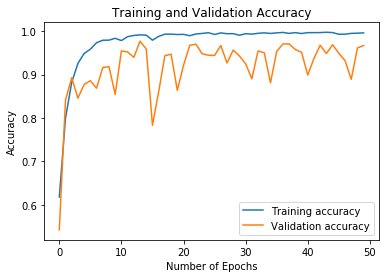

In [0]:
# summarize history for accuracy
plt.plot(sourcecode_model_train.history['acc'])
plt.plot(sourcecode_model_train.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
# plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right',bbox_to_anchor=(1, 0.1))
path = MAIN_FOLDER + 'Training_accuracy_{}.png'.format(datetime.datetime.now().isoformat())
# path = '/content/drive/colab/imgs/figures/Training_accuracy_{}.png'.format(datetime.datetime.now().isoformat())
plt.savefig(path)
plt.show()

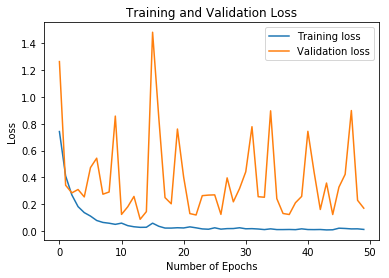

In [0]:
# summarize history for loss
plt.plot(sourcecode_model_train.history['loss'])
plt.plot(sourcecode_model_train.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
# plt.legend(['Training loss', 'Validation loss'], loc='upper right',bbox_to_anchor=(1, 0.9))
path = MAIN_FOLDER + 'Training and validation loss_{}.png'.format(datetime.datetime.now().isoformat())
# path = '/content/drive/colab/imgs/figures/Training and validation loss_{}.png'.format(datetime.datetime.now().isoformat())
plt.savefig(path)
plt.show()

In [0]:
predictions = sourcecode_model.predict([test_left, test_right], batch_size=batch_size)
predictions

array([[0.9723662],
       [0.7337851],
       [0.       ],
       ...,
       [0.       ],
       [0.9993049],
       [0.9007427]], dtype=float32)

In [0]:
rounded = [round(x[0]) for x in predictions]
y_pred = np.array(rounded,dtype='int64')
y_pred

array([1, 1, 0, ..., 0, 1, 1])

In [0]:
test_labels = np.array(test_labels, dtype='int64')
test_labels

array([1, 1, 0, ..., 0, 1, 1])

In [0]:
# rounded_predictions = np.array(np.argmax(predictions,axis=1))
# rounded_predictions = to_categorical(rounded_predictions, 2)
# # rounded_predictions = to_categorical(rounded_predictions, 2, dtype='int32')
# rounded_predictions

In [0]:
# print(test_labels)
# print(len(test_labels))
# print(test_labels[:,0])
# print(rounded_predictions[:,0])

# incorrects = np.nonzero(rounded_predictions[:,0] != test_labels[:,0])
# print(incorrects)
# print(len(incorrects[0]))
# main_information.append("Incorrectly predicted: {} from total {}".format(len(incorrects[0]), len(test_labels)))

### Find wrongly predicted results

In [0]:
# for i in incorrects:
#   print(test_left_original[i])
#   print(test_right_original[i])
#   print(test_labels[i])
#   print(rounded_predictions[7])
#   print("\n\n")

# wrong = incorrects[0][0]
# print(test_left_original[wrong])
# print(test_right_original[wrong])
# print("Test Labels", test_labels[wrong][1])
# print("Predected", rounded_predictions[wrong][1])
# print("\n\n")

# Display Metrics

## Confusion Matrix

In [0]:
# Confusion Matrix
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    matrix = [[1371, 33], [36, 1359]]
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
#     path = MAIN_FOLDER + 'confusion_matrix_{}.svg'.format(datetime.datetime.now().isoformat())
    path = '/content/drive/colab/confusion_matrix_{}.svg'.format(datetime.datetime.now().isoformat())
#     path = '/content/drive/colab/imgs/figures/confusion_matrix_{}.svg'.format(datetime.datetime.now().isoformat())
    plt.savefig(path)
    plt.show()

In [0]:
# LABELS = ["Not Similar", "Similar"]
# show_confusion_matrix(test_labels[:,0], rounded_predictions[:,0])

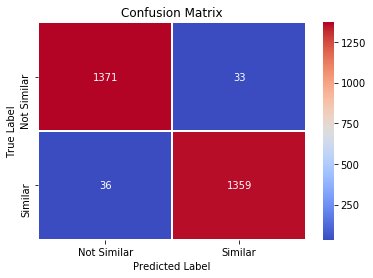

In [0]:
LABELS = ["Not Similar", "Similar"]
# show_confusion_matrix(test_labels, y_pred)
show_confusion_matrix([0,0], [0,1])

## Classification report

In [0]:
# Report with micro, macro and weighted avg
report = classification_report(test_labels, y_pred, output_dict=True, target_names=LABELS)
df = pd.DataFrame(report).transpose()

path = MAIN_FOLDER + 'classification_report_{}.csv'.format(datetime.datetime.now().isoformat())
# path = '/content/drive/colab/classification_reports/classification_report_{}.csv'.format(datetime.datetime.now().isoformat())
df.to_csv(path)
print(report)

{'Not Similar': {'precision': 0.980544747081712, 'recall': 0.96, 'f1-score': 0.9701636188642925, 'support': 1050}, 'Similar': {'precision': 0.9579158316633266, 'recall': 0.9795081967213115, 'f1-score': 0.9685916919959473, 'support': 976}, 'micro avg': {'precision': 0.9693978282329714, 'recall': 0.9693978282329714, 'f1-score': 0.9693978282329714, 'support': 2026}, 'macro avg': {'precision': 0.9692302893725193, 'recall': 0.9697540983606557, 'f1-score': 0.9693776554301199, 'support': 2026}, 'weighted avg': {'precision': 0.9696435518949676, 'recall': 0.9693978282329714, 'f1-score': 0.9694063628803316, 'support': 2026}}


In [0]:
# This one looks better, only average
from sklearn.metrics import precision_recall_fscore_support

clf_rep = precision_recall_fscore_support(test_labels, y_pred)
out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict, index = LABELS)
avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
avg_tot.index = ["avg/total"]
out_df = out_df.append(avg_tot)

path = MAIN_FOLDER + 'classification_report_{}.csv'.format(datetime.datetime.now().isoformat())
# path = '/content/drive/colab/classification_reports/classification_report_{}.csv'.format(datetime.datetime.now().isoformat())
out_df.to_csv(path)
print(out_df)

             precision  recall  f1-score  support
Not Similar       0.98    0.96      0.97   1050.0
Similar           0.96    0.98      0.97    976.0
avg/total         0.97    0.97      0.97   2026.0


## Precision vs Recall Curve

In [0]:
from sklearn.metrics import accuracy_score
print("Accuracy score: ", accuracy_score(y_pred, test_labels))
main_information.append("Accuracy score: {}".format(accuracy_score(y_pred, test_labels)))

Accuracy score:  0.9693978282329714


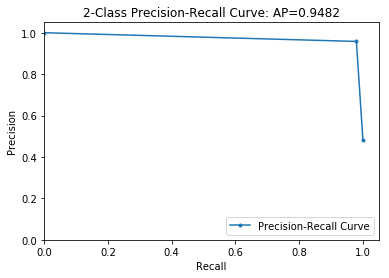

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature

precision, recall, threshold = precision_recall_curve(test_labels, y_pred)

average_precision = average_precision_score(test_labels, y_pred)

plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')

#### Should fill rectangle under the curve ####
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
###############################################

plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-Class Precision-Recall Curve: AP={0:0.4f}'.format(average_precision))
plt.legend(loc="lower right")

path = MAIN_FOLDER + 'precision_recall_curve_{}.svg'.format(datetime.datetime.now().isoformat())
# path = '/content/drive/colab/imgs/figures/precision_recall_curve_{}.png'.format(datetime.datetime.now().isoformat())
plt.savefig(path)
plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    # AUC - area under the curve, larger usually better
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
   
    path =  MAIN_FOLDER + 'roc_curve_{}.svg'.format(datetime.datetime.now().isoformat())
#     path = '/content/drive/colab/imgs/figures/roc_curve_{}.png'.format(datetime.datetime.now().isoformat())
    plt.savefig(path)
    plt.show()

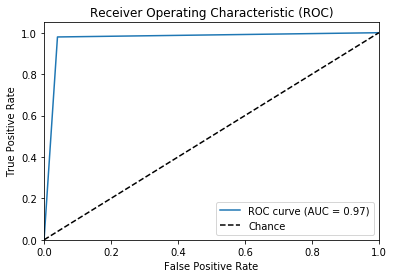

In [0]:
plot_roc( y_pred, test_labels )

# Save infomation

In [0]:
save_information(main_information)

Saved into /content/drive/colab/CNN/2019-04-20T01:41:10.424894/main_info.txt
